<a href="https://colab.research.google.com/github/AashiqDina/Uni_Neural_Networks_Project/blob/main/NeuralNetworksProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports:

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils import data
import torch.nn.functional as F
import sys
import time
import zipfile
from matplotlib import pyplot as plt
from IPython import display
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Device name: NVIDIA GeForce RTX 4060


# Read dataset and create dataloaders:

In [2]:
Util = sys.modules

# Set the data augmentation to be applied
trans = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip the image
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # add small colour changes,
    transforms.RandomRotation(15),
    transforms.ToTensor(), # converts rgb into colour intensities => (255, 0, 100) => (1.0, 0, 0.39)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # compares the colour intensities to the relative amount in the dataset, passes it on later
])

testTrans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Read Datasets
TrainDataset = torchvision.datasets.CIFAR10(root="../data", train=True, transform=trans, download=True)
TestDataset = torchvision.datasets.CIFAR10(root="../data", train=False, transform=testTrans, download=True)

# Create Dataloaders, 50,000 images per epoch => 128 per batch => 50,000/128 = ~391 batches
# Create Dataloaders, 50,000 images per epoch => 64 per batch => 50,000/64 = ~781 batches
TrainLoader = data.DataLoader(TrainDataset, batch_size=64, shuffle=True, num_workers=4)
TestLoader = data.DataLoader(TestDataset, batch_size=64, shuffle=False, num_workers=2)

# Blocks:

In [3]:
class Blocks(torch.nn.Module):
  def __init__(self, numberOfInputs, numberOfOutputs, First):
    super(Blocks, self).__init__()

    self.numberOfInputs = numberOfInputs
    self.numberOfOutputs = numberOfOutputs
    self.First = First

    # Below defines the convolutional layers
    if(First):
      self.Convl1 = nn.Conv2d(numberOfInputs, numberOfOutputs, kernel_size=5, padding=2)
      self.Convl2 = nn.Conv2d(numberOfInputs, numberOfOutputs, kernel_size=5, padding=2)
    else:
      self.Convl1 = nn.Conv2d(numberOfInputs, numberOfOutputs, kernel_size=5, padding=2)
      self.Convl2 = nn.Conv2d(numberOfInputs, numberOfOutputs, kernel_size=5, padding=2)
      self.Convl3 = nn.Conv2d(numberOfInputs, numberOfOutputs, kernel_size=5, padding=2)

    # Below defines batch normalisation to normalise the output if the Conv layers in relation to the number of input channels
    self.batchNormalisation1 = nn.BatchNorm2d(numberOfOutputs)
    self.batchNormalisation2 = nn.BatchNorm2d(numberOfOutputs)
    self.batchNormalisation3 = nn.BatchNorm2d(numberOfOutputs)

    # Below defines the linear layer
    self.Linear1 = nn.Linear(numberOfInputs,numberOfOutputs)

    # Below defined dropout to help with overfitting
    self.Dropout = nn.Dropout(0.12)

    # Below defined maxpooling
    self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Below is the chosen activation function
    self.LeakyRelu = nn.LeakyReLU(negative_slope=0.1)
    self.LeakyRelu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)

      #Below defined AdaptiveAveragePool2d to find the SpatialAveragePool
    self.Avg = nn.AdaptiveAvgPool2d(numberOfInputs)

  def forward(self, x):

    # Below each  Convolutional layer is declared in parallel and uses makes use of that was defined above
    Convl1X = self.Convl1(x)
    Convl1X = self.batchNormalisation1(Convl1X)
    Convl1X = self.LeakyRelu2(Convl1X)
    Convl1X = self.Dropout(Convl1X)
    Convl1X = self.Maxpool(Convl1X)

    Convl2X = self.Convl2(x)
    Convl2X = self.batchNormalisation2(Convl2X)
    Convl2X = self.LeakyRelu2(Convl2X)
    Convl2X = self.Dropout(Convl2X)
    Convl2X = self.Maxpool(Convl2X)

    # First Block will only have 2 convolutional layers
    if(not self.First):
        Convl3X = self.Convl3(x)
        Convl3X = self.batchNormalisation3(Convl3X)
        Convl3X = self.LeakyRelu2(Convl3X)
        Convl3X = self.Dropout(Convl3X)
        Convl3X = self.Maxpool(Convl3X)

    # Below finds the spatialAveragePool of x
    PooledValue = self.Avg(x)
    SqueezePooledValue = PooledValue.squeeze()

    # Below the linear transformation is applied
    LinearX = self.Linear1(SqueezePooledValue)
    LinearX = LinearX.reshape(LinearX.size(0), -1, 1, 1)
    LinearX = self.LeakyRelu(LinearX)

    # Declare a1,... from a (LinearX) above
    a1 = self.LeakyRelu(LinearX[:, 0].unsqueeze(1))
    a2 = self.LeakyRelu(LinearX[:, 1].unsqueeze(1))

    # a1,... is multiplied by the output of each convolutional layer to get the final output
    if(not self.First):
      a3 = self.LeakyRelu(LinearX[:, 2].unsqueeze(1))
      out = (a1 * Convl1X) + (a2 * Convl2X) + (a3 * Convl3X)
    else:
      out = (a1 * Convl1X) + (a2 * Convl2X)

    # return this final output
    return out

# Backbone:

In [4]:
class Backbone(nn.Module):
  def __init__(self, numberOfInputs, numberOfOutputs):
    super(Backbone, self).__init__()

    # Decalre the blocks
    self.Block1 = Blocks(numberOfInputs, numberOfOutputs, True,)
    self.Block2 = Blocks(numberOfOutputs, numberOfOutputs*2, False)
    self.Block3 = Blocks(numberOfOutputs*2, numberOfOutputs*4, False)
    self.Block4 = Blocks(numberOfOutputs*4, numberOfOutputs*8, False)

  def forward(self, x):

    #Pass x to the first block and the output of each block to the next
    OutputBlock = self.Block1(x)
    OutputBlock = self.Block2(OutputBlock)
    OutputBlock = self.Block3(OutputBlock)
    OutputBlock = self.Block4(OutputBlock)

    #return the output of the final block
    return OutputBlock

# Classifier:

In [5]:
class Classifier(nn.Module):
  def __init__(self, numberOfInputs):
    super(Classifier, self).__init__()

    # Declare final number of classes
    NumberOfClasses = 10

    # Defines the spatialAveragePool and the classifier
    self.Avg = nn.AvgPool2d(kernel_size=None)
    self.Linear1 = nn.Linear(numberOfInputs, NumberOfClasses)

  def forward(self, x):

    # Finds the spatialAveragePool and performs the classification
    self.Avg.kernel_size = x.shape[2:]
    PooledValue = self.Avg(x)
    FlatPooledValue = PooledValue.squeeze()
    out = self.Linear1(FlatPooledValue)

    return out


# Model:

In [6]:
class Model(nn.Module):
  def __init__(self, numberOfInputs, numberOfOutputs):
    super(Model, self).__init__()

    # Defines the backbone and classifier
    self.Backbone = Backbone(numberOfInputs, numberOfOutputs)
    self.Classifier = Classifier(numberOfOutputs*8)

  def forward(self, x):

    # Passes X to the backbone and the output of the backbone is passed through the classifier
    out = self.Backbone(x)
    out = self.Classifier(out)

    # returns the output of the classifier
    return out


In [7]:
# Declare the number of input and output channels
numberOfInputs = 3
numberOfOutputs = 16

# Declare the Model
Model = Model(numberOfInputs, numberOfOutputs)

# Loss and optimizer:

In [8]:
# Declare the loss, optimiser and scheduler
Loss = nn.CrossEntropyLoss()
LearningRate, NumberOfEpochs, batch_size, weightDecay = 0.001, 50, 128, 0.01
Optimizer = torch.optim.AdamW(Model.parameters(), lr=LearningRate, weight_decay=weightDecay)
Scheduler = torch.optim.lr_scheduler.StepLR(Optimizer, step_size=5, gamma=0.5)

# Training Script

In [9]:
class TrainingGraph:
    def __init__(self, NumberOfEpochs):
        self.Legend = ['Training Loss', 'Training Accuracy', 'Test Accuracy']
        from matplotlib_inline.backend_inline import set_matplotlib_formats
        set_matplotlib_formats('svg')
        self.Figure, self.Axes = plt.subplots(1, 1, figsize=(3.5, 2.5))
        self.Axes = [self.Axes, ]
        self.configureAxes = lambda: SetAxes(self.Axes[0], "Epoch", [0, NumberOfEpochs], 'linear', 'linear', self.Legend)
        self.X = None
        self.Y = None
        self.feat = ('-', 'c--', 'r-.', 'g:')

    def Add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        if not hasattr(x, "__len__"):
            x = [x] * len(y)
        if not self.Y:
            self.Y = [[] for _ in range(len(y))]
        if not self.X:
            self.X = [[] for _ in range(len(y))]
        for i, (a, b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.Axes[0].cla()
        for x, y, ftr in zip(self.X, self.Y, self.feat):
            self.Axes[0].plot(x, y, ftr)
        self.configureAxes()
        display.display(self.Figure)
        display.clear_output(wait=True)

In [10]:
class ToSum:
    def __init__(self, n):
        self.data = [0.0] * n

    def Add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
def argmax(x, *args, **kwargs):
    out = x.argmax(*args, **kwargs)
    return out

def astype(x, *args, **kwargs):
    out = x.type(*args, **kwargs)
    return out

def ReduceSum(x, *args, **kwargs):
    out = x.sum(*args, **kwargs)
    return out

def size(x, *args, **kwargs):
    out = x.numel(*args, **kwargs)
    return out

def Accuracy(yHat, y):
    if len(yHat.shape) > 1 and yHat.shape[1] > 1:
        yHat = argmax(yHat, axis=1)
    x = astype(yHat, y.dtype) == y
    return float(ReduceSum(astype(x, y.dtype)))

def GetTestAccuracy(Model, TestLoader):
    Model.eval()
    device = next(iter(Model.parameters())).device
    Index = ToSum(2)
    for X, Y in TestLoader:
        X = X.to(device)
        Y = Y.to(device)
        Index.Add(Accuracy(Model(X), Y), size(Y))
    return Index[0]/Index[1]

def SetAxes(Axes, xlabel, xlim, xscale, yscale, legend):
    Axes.set_xlabel(xlabel)
    Axes.set_xscale(xscale)
    Axes.set_yscale(yscale)
    Axes.set_xlim(xlim)
    Axes.legend(legend)
    Axes.grid()

def Train(Model, TrainLoader, TestLoader, Device):
    Model.to(Device)
    TheTrainingGraph = TrainingGraph(NumberOfEpochs)
    for epochs in range(NumberOfEpochs):
        print("Epoch: ", epochs, "/", NumberOfEpochs)
        Index = ToSum(3)
        for i, (X, Y) in enumerate(TrainLoader):
            Model.train()
            Optimizer.zero_grad()
            X, Y = X.to(device), Y.to(device)
            yHat = Model(X)
            TheLoss = Loss(yHat, Y)
            TheLoss.backward()
            Optimizer.step()
            with torch.no_grad():
                Index.Add(TheLoss*X.shape[0], Accuracy(yHat, Y), X.shape[0])
            TrainLoss = Index[0]/Index[2]
            TrainAccuracy = Index[1]/Index[2]
            if(i+1) % 50 == 0:
                TheTrainingGraph.Add(epochs + i/len(TrainLoader), (TrainLoss, TrainAccuracy, None))
        if(epochs > 20):
            Scheduler.step()
        TestAccuracy = GetTestAccuracy(Model, TestLoader)
        print(TestAccuracy)
        TheTrainingGraph.Add(epochs+1, (None, None, TestAccuracy))
        print("Loss:", round(TrainLoss, 3))
        print("Training Accuracy: ", round(TrainAccuracy, 3), " (",round(TrainAccuracy, 3)*100,"%)")
        print("Test Accuracy: ", round(TestAccuracy, 3), " (",round(TestAccuracy, 3)*100,"%)")

Loss: 0.239
Training Accuracy:  0.917  ( 91.7 %)
Test Accuracy:  0.844  ( 84.39999999999999 %)


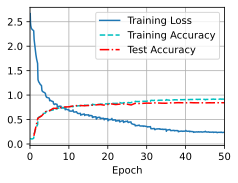

In [12]:
# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)
# Use training script to train the model
Train(Model, TrainLoader, TestLoader, device)